<a href="https://colab.research.google.com/github/CIA-Oceanix/DLGD2022/blob/main/tutorial-1-hydra/DLGD2022_tuto_hydra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training an ocean forecast model: a configuration management use case: 


#### Install dependencies and download data

In [1]:
!pip install xarray hvplot hydra-core torchmetrics -q
!wget -nc https://s3.us-east-1.wasabisys.com/melody/osse_data/ref/NATL60-CJM165_GULFSTREAM_ssh_y2013.1y.nc
!wget -nc https://s3.us-east-1.wasabisys.com/melody/osse_data/ref/NATL60-CJM165_GULFSTREAM_sst_y2013.1y.nc

     |████████████████████████████████| 3.2 MB 14.0 MB/s 
     |████████████████████████████████| 151 kB 93.3 MB/s 
     |████████████████████████████████| 529 kB 64.5 MB/s 
     |████████████████████████████████| 117 kB 73.9 MB/s 
     |████████████████████████████████| 79 kB 8.6 MB/s 
--2022-11-15 09:52:09--  https://s3.us-east-1.wasabisys.com/melody/osse_data/ref/NATL60-CJM165_GULFSTREAM_ssh_y2013.1y.nc
Resolving s3.us-east-1.wasabisys.com (s3.us-east-1.wasabisys.com)... 38.27.106.51, 38.27.106.53
Connecting to s3.us-east-1.wasabisys.com (s3.us-east-1.wasabisys.com)|38.27.106.51|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://s3.eu-central-1.wasabisys.com/melody/osse_data/ref/NATL60-CJM165_GULFSTREAM_ssh_y2013.1y.nc [following]
--2022-11-15 09:52:09--  https://s3.eu-central-1.wasabisys.com/melody/osse_data/ref/NATL60-CJM165_GULFSTREAM_ssh_y2013.1y.nc
Resolving s3.eu-central-1.wasabisys.com (s3.eu-central-1.wasabisys.com)... 130.117.

In [2]:
!git clone https://github.com/CIA-Oceanix/DLGD2022.git --branch tuto-hydra --depth=1

Cloning into 'DLGD2022'...
remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 37 (delta 2), reused 14 (delta 0), pack-reused 0
Unpacking objects: 100% (37/37), done.


In [10]:
!cd DLGD2022/tutorial-1-hydra

In [3]:
import sys
sys.path.append('DLGD2022/tutorial-1-hydra')

# Project Walkthrough

In [4]:
#@title Imports
import xarray as xr
import pandas as pd
import scipy.ndimage as ndi
import numpy as np
import holoviews as hv
import torch
import hydra
import functools
hv.extension('matplotlib')

import src


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W


############### function reading data : src.load_ssh ###############

<xarray.DataArray 'ssh' (time: 365, lat: 201, lon: 201)>
[14746365 values with dtype=float64]
Coordinates:
  * lon      (lon) float64 -65.0 -64.95 -64.9 -64.85 ... -55.1 -55.05 -55.0
  * lat      (lat) float64 33.0 33.05 33.1 33.15 33.2 ... 42.85 42.9 42.95 43.0
  * time     (time) datetime64[ns] 2012-10-01T12:00:00 ... 2013-09-30T12:00:00

############### Animation preview ###############



:HoloMap   [time]
   :QuadMesh   [lon,lat]   (ssh)
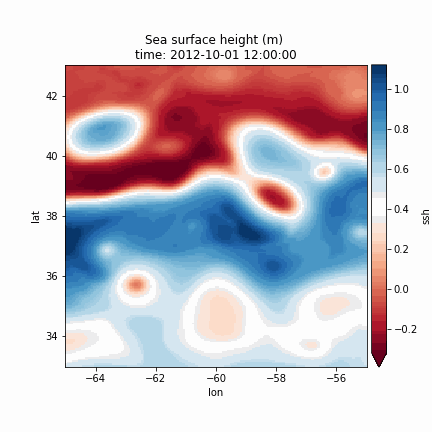

In [5]:
#@title Read data
print('\n############### function reading data : src.load_ssh ###############\n' )
#help(src.load_ssh)
ssh_da = src.load_ssh()
print(ssh_da)


print('\n############### Animation preview ###############\n' )

def anim(da, name, climda=None):
    climda = climda if climda is not None else da
    clim = climda.pipe(lambda da: (da.quantile(0.005).item(), da.quantile(0.995).item()))
    return  (hv.Dataset(da)
            .to(hv.QuadMesh, ['lon', 'lat']).relabel(name)
            .options(cmap='RdBu',clim=clim, colorbar=True))

hv.output(
    anim(ssh_da.isel(time=slice(None,30, 2)), 'Sea surface height (m)'),
    holomap='gif', fps=2, dpi=50, size=150)

* Data taken from an ocean simulation
* Ocean surface topography relates to surface currents

**Objective : Given the sea surface height (SSH) from the N last days $[D_{-N+1}, D_{-N +2},..., D_{0}]$, estimate the  SSH at $D_{+1}$**

In [6]:
print('\n############### function instantiating dataloaders: src.dataloaders ###############\n' )
#help(src.dataloaders)

train_dl, val_dl = src.dataloaders(
    ssh_da,
    training_periods=[slice('2013-01-01', '2013-09-30')],
    validation_periods=[slice('2012-10-01', '2012-12-31')],
    number_of_past_days=5,
    batch_size=16
)

x, y = next(iter(train_dl))
print(f"""
input shape: \t\t\t {x.shape}
target shape: \t\t\t {y.shape} \n
number of training batches: \t {len(train_dl)}
number of validation batches: \t {len(val_dl)}
""")


############### function instantiating dataloaders: src.dataloaders ###############


input shape: 			 torch.Size([16, 5, 201, 201])
target shape: 			 torch.Size([16, 1, 201, 201]) 

number of training batches: 	 17
number of validation batches: 	 6



![](https://i.imgur.com/4xx5TdM.png)

In [7]:
print('\n############### function training model: src.train ###############\n\n' )
#help(src.train)

model = src.train(
    model=torch.nn.Conv2d(5, 1, kernel_size=5, padding=2),
    partial_optimizer=functools.partial(torch.optim.Adam, lr=3e-3),
    dataloaders=(train_dl, val_dl),
    n_epochs=50
)


############### function training model: src.train ###############




Epoch: 49 	 - train err: 0.037 - val err: 0.030 (base err: 0.035) (m): 100%|██████████| 50/50 [01:06<00:00,  1.33s/it]


![](https://i.imgur.com/4raqoYs.png)

In [8]:
print('############### function computing forecast metrics: src.forecast_diagnostic ###############\n' )
#help(src.forecast_diagnostic)

xrds, metrics_df = src.forecast_diagnostic(model, val_dl, number_of_forecast_days=5)
print(metrics_df.to_markdown())

############### function computing forecast metrics: src.forecast_diagnostic ###############

|                        |   day + 1 |   day + 2 |   day + 3 |   day + 4 |   day + 5 |
|:-----------------------|----------:|----------:|----------:|----------:|----------:|
| persistence error (cm) |      3.48 |      6.25 |      8.61 |     10.61 |     12.33 |
| forecast error (cm)    |      2.95 |      5.3  |      7.61 |      9.61 |     11.4  |
| improvement (%)        |     15.12 |     15.2  |     11.6  |      9.41 |      7.56 |


![](https://i.imgur.com/et6sMye.png)

# The problem

## Given a project structured liked this:

```python
##################### main.py #####################

# Training data
train_dl, val_dl = src.dataloaders(
    dataarray=src.load_ssh(), 
    training_periods=[slice('2013-01-01', '2013-09-30')],
    validation_periods=[slice('2012-10-01', '2012-12-31')],
    number_of_past_days=5,
    batch_size=16
)

# Train model
model = src.train(
    model=torch.nn.Conv2d(5, 1, kernel_size=5, padding=2),
    partial_optimizer=functools.partial(torch.optim.Adam, lr=8e-3),
    dataloaders=(train_dl, val_dl),
    n_epochs=50
)

# Generate metrics
xrds, metrics_df = src.forecast_diagnostic(model, val_dl, number_of_forecast_days=5)
print(metrics_df.to_markdown())
```

## Let's say I want to run some additional experiments using this project:


- What if I evaluate on the summer season and test on the rest of the year (**change train/val split**) 
- What is the impact of the number of input days (**change input format**)
- What is the impact of the batch_size and learning rate (**change  training hyperparameters**)
- What other model architecture might work better (**change classes and parameters**)
- What results do I get if I train a model to forecast sea surface temperature instead of sea surface height (**change dataset**)

## But I don't want to:
- turn my code into spaghetti code
- break previous experiments when designing new ones


## In order to be able to:

- reproduce "any" intermediate results
- Collaborate with other people:
    - Share my results with people using the same project
    - Run some experiments designed by someone else and "quickly understand" what has changed
    - Use some config or code developped by someone else in my experiments 
 
----------

## **How would YOU do it ?**




# Possible DIY solutions


- Change the values inside main.py ?
- Duplicate main.py and change some values ?
- Add if statements for each case ?
- Move the "configurables" to a different file and read it in main.py
    * duplicate the config and change the relevant fields 
    * read arguments from the command line

----------- 

## Some personal comments:
- With duplication comes some maintanability issues when an interface changes
- With duplication + modifications it may be hard to track what changes have been made 
- Having a lot of if statements in a file may render the code difficult to read / share
- modifying scripts may make difficult to remember which source code and parameters were used and to produce some results
- Using configuration files, it may make difficult to switch between different configs without modifying the source code (e.g network architecture)


# The [Hydra](https://hydra.cc/) solution



## Restructure the `main.py` to `hydra_main.py` and `config/main.yaml`


### In `config.yaml`:

- use `${now:'%y-%m-%d--%H-%M-%S'}` to inject the formatted date in the config
- use `${path.to.node}` to reuse a config value 
- use node with the `_target_` key to point to python classes or function
- use the `defaults` key to combine the config from multiple files 


```yaml
##################### config/main.yaml #####################
logdir: hydra_logs/${now:'%y-%m-%d--%H-%M-%S'}
data:
    _target_: src.dataloaders
    dataarray: {_target_: "src.load_ssh"}
    training_periods:
        - {_target_: "builtins.slice", _args_:["2013-01-01", "2013-09-30"]} # slice("2013-01-01", "2013-09-30")
    validation_periods: 
        - {_target_: "builtins.slice", _args_:["2012-10-01", "2012-12-31"]}
    batch_size: 16
    number_of_past_days: 5
training:
    _target_: src.train
    model: ${model}
    partial_optimizer:
        _target_: torch.optim.Adam
        lr: 0.008
        _partial_: true # functools.partial(torch.optim.Adam, lr=0.008)
    n_epochs: 50
diagnostic:
    _target_: src.forecast_diagnostic
    number_of_forecast_days: ${data.number_of_past_days} 

defaults:
    - model: simple_conv  # Load config/model/simple_conv.yaml config in "model" key
```

```yaml
##################### config/model/simple_conv.yaml #####################
_target_: torch.nn.Conv2d
in_channels: ${data.number_of_past_days}
out_channels: 1
kernel_size: 5
padding: 2
```


-------------

### In `hydra_main.py`:

- use the `hydra.main` decorator to inject the config in the main function
- use `hydra.utils.call` to instantiate or call functions from the configuration (nodes with `_target_`)


```python
##################### hydra_main.py #####################

@hydra.main(config_path='config', config_name='main', version_base="1.2")
def main(cfg):
    # Training data
    train_dl, val_dl = hydra.utils.call(cfg.data) 
    
    # Training model
    model = hydra.utils.call(cfg.training, dataloaders=(train_dl, val_dl))

    # Compute diagnostics
    xrds, metrics_df = hydra.utils.call(cfg.diagnostic, model=model, dl=val_dl)
    print(metrics_df.to_markdown())


if __name__ =='__main__':
    main()
```

-----------

### Run with:

```sh
python DLGD2022/tutorial-1-hydra/hydra_main.py
```



## Extending the project using hydra

### Use and save set of parameters

**Run a job and modify parameters on the fly**
```
python DLGD2022/tutorial-1-hydra/hydra_main.py  \ 
                    data.number_of_past_days=7 \
                    data.batch_size=8 \   
                    training.partial_optimizer=0.002    
```



**Or save this specific config and call it from the CLI : `config/xp/my_params.yaml`**
```yaml
#@package _global_
data:
    number_of_past_days: 7
    batch_size: 8
training:
    partial_optimizer:
        lr: 2e-3
```

Run with
```
python hydra_main.py +xp=my_params
```


### Extend the code and use it in the config



#### Write some new python module **new_src.py**


```python
################################ new_src.py ################################
def load_sst():
    """Return Sea surface temperature xarray dataarray"""
    return xr.open_dataset('NATL60-CJM165_GULFSTREAM_sst_y2013.1y.nc').sst


class MyForecastModel(torch.nn.Module):
    def __init__(self, ninput, nhidden, nlayers, kernel_size=3, residual=False):
        super().__init__()
        assert kernel_size % 2 ==1, "Please use odd kernel_size" 
        self.residual = residual
        in_channel, out_channel = ninput, nhidden
        self.net = torch.nn.Sequential()

        for layer in range(nlayers):
            self.net.add_module(f'conv_{layer}', torch.nn.Conv2d(in_channel, out_channel, kernel_size, padding=kernel_size//2))
            self.net.add_module(f'bn_{layer}',torch.nn.BatchNorm2d(out_channel))
            self.net.add_module(f'act_{layer}',torch.nn.ReLU())
            in_channel = out_channel
        
        self.net.add_module(f'conv_out',torch.nn.Conv2d(in_channel, 1, kernel_size, padding=kernel_size//2))


    def forward(self, x):
        out = self.net(x)
        if self.residual:
            return x[:, -1:] + out
        return out
```

----

####  Add a new model configuration **config/model/small_cnn.yaml**


```yaml
################################ new_src.py ################################
_target_: new_src.MyForecastModel
ninput: ${data.number_of_past_days}
nhidden: 16
nlayers: 1
```


-----------


#### Then use it directly in the CLI ...

```bash
python DLGD2022/tutorial-1-hydra/hydra_main.py \ 
    model=small_cnn \ 
    data.dataarray._target_=new_src.load_sst
```


--------

#### Or save it in a specific config file **config/xp/sst_small_cnn.yaml** and use it in the cli


```yaml
# @package _global_ 
data:
    dataarray: {_target_: new_src.load_sst}
training:
    partial_optimizer:
        lr: 1e-3
defaults:
    - override /model: small_cnn
```


```bash
python DLGD2022/tutorial-1-hydra/hydra_main.py +xp=sst_small_cnn
```

### Run

In [13]:
!python DLGD2022/tutorial-1-hydra/hydra_main.py +xp=sst_small_cnn 

########################## Job config ##########################
model:
  _target_: new_src.MyForecastModel
  ninput: 5
  nhidden: 16
  nlayers: 1
  residual: true
logdir: hydra_logs/22-11-15--10-15-29
data:
  _target_: src.dataloaders
  dataarray:
    _target_: new_src.load_sst
  training_periods:
  - _target_: builtins.slice
    _args_:
    - '2013-01-01'
    - '2013-09-30'
  validation_periods:
  - _target_: builtins.slice
    _args_:
    - '2012-10-01'
    - '2012-12-31'
  batch_size: 16
  number_of_past_days: 5
training:
  _target_: src.train
  model:
    _target_: new_src.MyForecastModel
    ninput: 5
    nhidden: 16
    nlayers: 1
    residual: true
  partial_optimizer:
    _target_: torch.optim.Adam
    lr: 0.001
    _partial_: true
  n_epochs: 50
diagnostic:
  _target_: src.forecast_diagnostic
  number_of_forecast_days: 5

[2022-11-15 10:15:30,043][numexpr.utils][INFO] - NumExpr defaulting to 2 threads.
Epoch: 49 	 - train err: 0.511 - val err: 0.433 (base err: 0.517) (m): 100

# Takeaways

Thanks to the hydra library we were able to:
- Store another training configuration in `config/xp/my_params.yaml`
- Extend the project with a new data source and a new model and use them in new experiments

And doing this:
- We only specified the parameters that change w.r.t. the base experiments -> **Easier to read and to understand**
- We didn't change the code or the config of the base experiment ->  **We know we didn't break the initial training**



**To know more, go to the doc https://hydra.cc/**

# To try it yourself:
- Go to the github repo https://github.com/CIA-Oceanix/DLGD2022
- Open the notebook tutorial-1-hydra/main_notebook.ipynb
- Run some of your own experiments **without** changing existing files
- Try sharing your experiments with your friends
- Try running experiments developped by your friends

# Bonus

## Sweep over multiple parameters values

In [ ]:


# We can sweep over multiple values at once
!python DLGD2022/tutorial-1-hydra/hydra_main.py --multirun \
            training.partial_optimizer.lr=0.01,0.005,0.001 # try different learning rate

## Use hydra from a notebook

In [ ]:
import hydra
from hydra.core.config_store import ConfigStore
from omegaconf import OmegaConf

# create configs programatically
cs = ConfigStore.instance()
cs.store(
    name='medium_cnn', 
    node={
        '_target_': 'new_src.MyForecastModel',
        'ninput': '${data.number_of_past_days}',
        'nhidden': 32,
        'nlayers': 2,
    }, group='model', package='model'
)



# Compose configs explicitely
with hydra.initialize(config_path='config', version_base='1.2'):
    cfg = hydra.compose('main', overrides=['model=medium_cnn'])

print(OmegaConf.to_yaml(cfg.model))

_target_: new_src.MyForecastModel
ninput: ${data.number_of_past_days}
nhidden: 32
nlayers: 2



## Use hydra to manage your slurm job configurations : [See doc](https://hydra.cc/docs/plugins/submitit_launcher/)


## Use hydra to help with your hyperparameter search: [See doc](https://hydra.cc/docs/plugins/optuna_sweeper/)
